# 1. Importing modules and functions

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.model_selection import permutation_test_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import joblib
import pickle
from numpy import savetxt
from padelpy import from_sdf
import shap
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [4]:
import glob
xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()
xml_files

['fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'fingerprints_xml\\EStateFingerprinter.xml',
 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'fingerprints_xml\\Fingerprinter.xml',
 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'fingerprints_xml\\MACCSFingerprinter.xml',
 'fingerprints_xml\\PubchemFingerprinter.xml',
 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'fingerprints_xml\\SubstructureFingerprinter.xml']

In [5]:
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [6]:
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

# 2.Data entry and curation work set

In [8]:
uploaded_file_ws="datasets/KRAS_work_from_insilico.sdf"
supplier_ws = Chem.ForwardSDMolSupplier(uploaded_file_ws,sanitize=False)
failed_mols_ws = []
all_mols_ws =[]
wrong_structure_ws=[]
wrong_smiles_ws=[]
y_tr = []
y_bad_index=[]

for i, m in enumerate(supplier_ws):
    structure = Chem.Mol(m)
    all_mols_ws.append(structure)
    y_tr.append(m.GetProp("pIC50_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ws.append(m)
        wrong_smiles_ws.append(Chem.MolToSmiles(m))
        wrong_structure_ws.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ws), 'molecules')
print('Failed data: ', len(failed_mols_ws), 'molecules')
number_ws =[]
for i in range(len(failed_mols_ws)):
        number_ws.append(str(i+1))
bad_molecules_ws = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ws, 'SMILES of wrong structure: ': wrong_smiles_ws, 'No.': number_ws}, index=None)
bad_molecules_ws = bad_molecules_ws.set_index('No.')
bad_molecules_ws

Original data:  452 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [10]:
y_tr[:] = [x for i,x in enumerate(y_tr) if i not in y_bad_index]

In [11]:
len(y_tr)

452

# 3.Standardization SDF file for work set

In [13]:
all_mols_ws[:] = [x for i,x in enumerate(all_mols_ws) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ws)):
    record = Chem.MolToSmiles(all_mols_ws[i])
    records.append(record)

moldf_ws = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ws.append(m)
    
print('Kept data: ', len(moldf_ws), 'molecules')

Kept data:  452 molecules


In [14]:
records_ws = []
for i in range(len(moldf_ws)):
    record = Chem.MolToSmiles(moldf_ws[i])
    records_ws.append(record)

In [15]:
df = pd.DataFrame(records_ws, columns=["Smiles"])
df.to_csv('datasets/molecule_ws.smi', sep=',', index=False, header=False)

# 4.Data entry and curation test set

In [17]:
uploaded_file_ts="datasets/KRAS_test_from_insilico.sdf"
supplier_ts = Chem.ForwardSDMolSupplier(uploaded_file_ts,sanitize=False)
failed_mols_ts = []
all_mols_ts =[]
wrong_structure_ts=[]
wrong_smiles_ts=[]
y_ts = []
y_bad_index=[]
for i, m in enumerate(supplier_ts):
    structure = Chem.Mol(m)
    all_mols_ts.append(structure)
    y_ts.append(m.GetProp("pIC50_mean"))
    try:
        Chem.SanitizeMol(structure)
    except:
        failed_mols_ts.append(m)
        wrong_smiles_ts.append(Chem.MolToSmiles(m))
        wrong_structure_ts.append(str(i+1))
        y_bad_index.append(i)
print('Original data: ', len(all_mols_ts), 'molecules')
print('Failed data: ', len(failed_mols_ts), 'molecules')
number_ts =[]
for i in range(len(failed_mols_ts)):
        number_ts.append(str(i+1))
bad_molecules_ts = pd.DataFrame({'No. failed molecule in original set': wrong_structure_ts, 'SMILES of wrong structure: ': wrong_smiles_ts, 'No.': number_ts}, index=None)
bad_molecules_ts = bad_molecules_ts.set_index('No.')
bad_molecules_ts

Original data:  114 molecules
Failed data:  0 molecules


,No. failed molecule in original set,SMILES of wrong structure:
No.,,


deleting activity values for substances with incorrect structure

In [19]:
y_ts[:] = [x for i,x in enumerate(y_ts) if i not in y_bad_index]

In [20]:
len(y_ts)

114

# 5.Standardization SDF file for test set

In [22]:
all_mols_ts[:] = [x for i,x in enumerate(all_mols_ts) if i not in y_bad_index] 
records = []
for i in range(len(all_mols_ts)):
    record = Chem.MolToSmiles(all_mols_ts[i])
    records.append(record)

moldf_ts = []
for i,record in enumerate(records):
    standard_record = standardize_smiles(record)
    m = Chem.MolFromSmiles(standard_record)
    moldf_ts.append(m)
    
print('Kept data: ', len(moldf_ts), 'molecules')

Kept data:  114 molecules


In [23]:
records_ts = []
for i in range(len(moldf_ts)):
    record = Chem.MolToSmiles(moldf_ts[i])
    records_ts.append(record)

In [24]:
df_ts = pd.DataFrame(records_ts, columns=["Smiles"])
df_ts.to_csv('datasets/molecule_ts.smi', sep=',', index=False, header=False)

# 6.Descriptor calculation for work set

In [42]:
fp

{'AtomPairs2DCount': 'fingerprints_xml\\AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'fingerprints_xml\\AtomPairs2DFingerprinter.xml',
 'EState': 'fingerprints_xml\\EStateFingerprinter.xml',
 'CDKextended': 'fingerprints_xml\\ExtendedFingerprinter.xml',
 'CDK': 'fingerprints_xml\\Fingerprinter.xml',
 'CDKgraphonly': 'fingerprints_xml\\GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'fingerprints_xml\\KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'fingerprints_xml\\KlekotaRothFingerprinter.xml',
 'MACCS': 'fingerprints_xml\\MACCSFingerprinter.xml',
 'PubChem': 'fingerprints_xml\\PubchemFingerprinter.xml',
 'SubstructureCount': 'fingerprints_xml\\SubstructureFingerprintCount.xml',
 'Substructure': 'fingerprints_xml\\SubstructureFingerprinter.xml'}

### PubChem FPs

In [43]:
from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'.csv']) 
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ws.smi', 
                d_file=fingerprint_output_file, 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [44]:
descriptors_PubChem = pd.read_csv('PubChem.csv')

In [46]:
descriptors_PubChem

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,AUTOGEN_molecule_ws_1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,AUTOGEN_molecule_ws_2,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,AUTOGEN_molecule_ws_3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AUTOGEN_molecule_ws_4,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AUTOGEN_molecule_ws_5,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,AUTOGEN_molecule_ws_448,1,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
448,AUTOGEN_molecule_ws_449,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
449,AUTOGEN_molecule_ws_450,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
450,AUTOGEN_molecule_ws_451,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
descriptors_ws = descriptors_PubChem.drop('Name', axis=1)

In [121]:
descriptors_ws[descriptors_ws['PubchemFP699']==1]

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
20,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
31,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
446,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
447,1,1,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
448,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
449,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [50]:
x_tr = np.array(descriptors_ws, dtype=np.float32)
y_tr = np.array(y_tr, dtype=np.float32)

In [52]:
savetxt('Models/Padels/x_tr_PubChem.csv', x_tr, delimiter=',')

In [54]:
x_tr.shape

(452, 881)

# 7.Descriptor calculation for test set

In [51]:
from padelpy import padeldescriptor

fingerprint = 'PubChem'

fingerprint_output_file = ''.join([fingerprint,'_ts.csv']) #PubChem.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='datasets/molecule_ts.smi', 
                d_file=fingerprint_output_file, #'PubChem.csv'
                #descriptortypes='PubChem.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=False,
                fingerprints=True)

In [56]:
descriptors_PubChem_ts = pd.read_csv('PubChem_ts.csv')

In [58]:
x_ts = descriptors_PubChem_ts.drop('Name', axis=1)

In [60]:
desc_ts=x_ts

In [55]:
x_ts.shape

(114, 881)

 # BASELINE GradientBoostingRegressor

In [67]:
seed = 42

In [69]:
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [59]:
%%time
model = CatBoostRegressor()
parameters = {'depth' : [6,8,10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations'    : [100,500, 1000]
              }

grid = GridSearchCV(estimator=model, param_grid = parameters, n_jobs=-1, cv = cv)
grid.fit(x_tr, y_tr, verbose=False)

CPU times: total: 1min 24s
Wall time: 20min 17s


,estimator,<catboost.cor...002E76D329DF0>
,param_grid,"{'depth': [6, 8, ...], 'iterations': [100, 500, ...], 'learning_rate': [0.01, 0.05, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False


In [60]:
best_CatBR = grid.best_estimator_

In [61]:
grid.best_params_

{'depth': 8, 'iterations': 500, 'learning_rate': 0.05}

In [71]:
params={'verbose': False}

In [73]:
%%time
y_pred_CV_CatBR = cross_val_predict(best_CatBR, x_tr, y_tr, cv=cv, params=params)

CPU times: total: 4min 27s
Wall time: 29 s


In [74]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_CatBR), 2)
Q2_CV

0.58

In [75]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_CatBR)), 2)
RMSE_CV

0.79

In [79]:
y_pred_GBR = best_CatBR.predict(desc_ts)

In [81]:
Q2_TS = round(r2_score(y_ts, y_pred_GBR), 2)
Q2_TS

0.65

In [83]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_GBR)), 2)
RMSE_TS

0.73

save the model to disk

In [100]:
pickle.dump(best_CatBR, open('Models/Padels/CatBoost_PubChem.pkl', 'wb'))

# load the model from disk

In [65]:
best_CatBR = pickle.load(open('Models/Padels/CatBoost_PubChem.pkl', 'rb'))

# Calculate Feature Importance

In [87]:
data = pd.DataFrame({'feature_importance': best_CatBR.get_feature_importance(), 
              'feature_names': descriptors_ws.columns}).sort_values(by=['feature_importance'], 
                                                       ascending=False)

<Axes: ylabel='feature_names'>

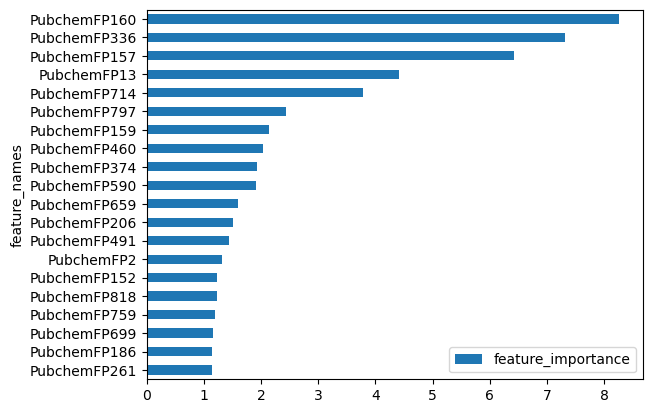

In [89]:
data[:20].sort_values(by=['feature_importance'], ascending=True).plot.barh(x='feature_names', y='feature_importance')

In [92]:
import shap

In [94]:
explainer = shap.Explainer(best_CatBR)

In [96]:
shap_values = explainer(descriptors_ws)

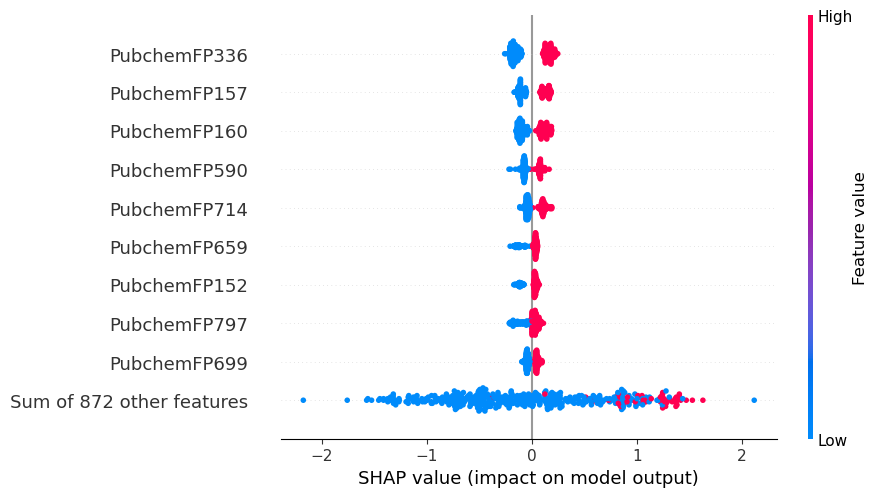

In [98]:
shap.plots.beeswarm(shap_values)

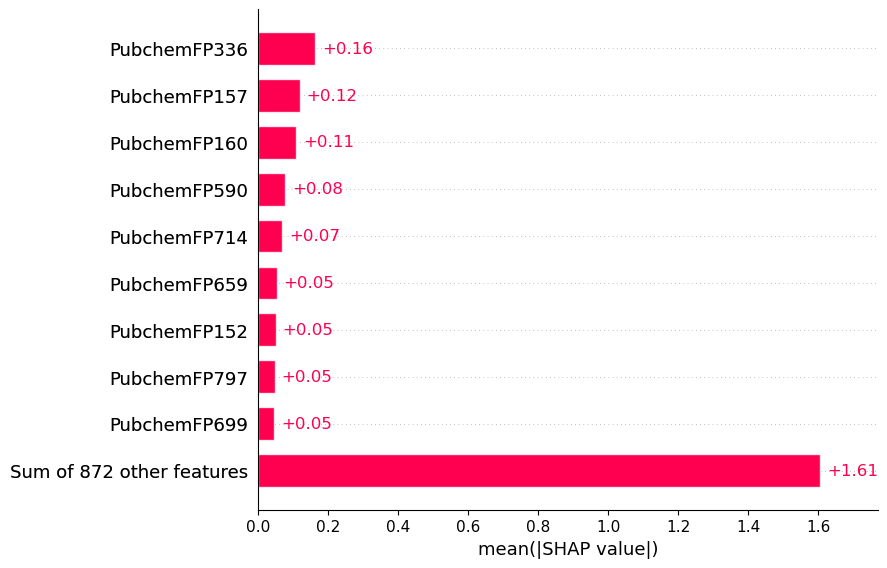

In [100]:
shap.plots.bar(shap_values)

# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [103]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [105]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,442,443,444,445,446,447,448,449,450,451
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.741657,5.291502,1.414214,2.236068,3.741657,4.472136,1.000000,3.741657,2.000000,4.123106,...,1.414214,0.000000,1.414214,2.449490,1.414214,1.000000,3.162278,1.000000,1.000000,2.236068
2,3.741657,5.567764,1.414214,3.741657,4.000000,4.795832,1.000000,3.741657,5.916080,4.242640,...,3.316625,1.000000,1.732051,3.872983,3.316625,2.000000,3.316625,1.732051,2.000000,2.236068
3,3.872983,6.082763,2.000000,4.123106,4.000000,5.291502,2.236068,3.872983,6.000000,4.242640,...,3.464102,1.000000,1.732051,4.000000,3.464102,2.236068,3.316625,2.000000,2.000000,2.236068
4,4.000000,6.244998,2.236068,4.358899,4.123106,5.291502,2.828427,4.242640,6.082763,4.358899,...,3.464102,1.732051,1.732051,4.000000,3.464102,2.236068,3.464102,2.449490,2.236068,2.449490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,10.148891,10.677078,9.797959,9.643651,9.219544,9.539392,9.797959,9.848858,10.816654,9.797959,...,9.165152,9.591663,8.831760,9.848858,9.219544,9.273619,9.746795,9.219544,9.055386,9.591663
448,10.198039,10.677078,9.899495,9.899495,9.273619,9.643651,9.848858,9.848858,10.862781,9.899495,...,9.273619,9.695360,9.000000,10.099504,9.380832,9.273619,9.746795,9.219544,9.273619,9.591663
449,10.198039,10.770329,9.899495,9.899495,9.539392,9.797959,10.344080,9.848858,10.954452,9.899495,...,9.433981,9.746795,9.327379,10.148891,9.433981,9.273619,9.797959,9.273619,9.486833,9.899495
450,10.295630,10.770329,10.148891,9.899495,9.643651,9.899495,10.488089,9.848858,11.045361,10.000000,...,9.539392,9.797959,9.380832,10.344080,9.433981,9.380832,9.949874,9.327379,9.539392,10.000000


In [107]:
similarity= neighbors_k

In [108]:
Dmean=np.mean(similarity[1,:])

In [109]:
round(Dmean, 2)

1.94

In [110]:
std=np.std(similarity[1,:])

In [111]:
round(std, 2)

1.24

In [112]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.56


In [113]:
neighbors_k_ts= pairwise_distances(x_tr,Y=desc_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [118]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,3.000000,2.645751,1.000000,2.236068,3.605551,5.291503,1.414214,3.741657,2.000000,2.000000,...,3.000000,2.236068,1.732051,1.414214,1.000000,1.732051,1.000000,1.000000,2.236068,0.000000
1,4.358899,2.828427,1.414214,3.316625,3.605551,5.656854,1.732051,3.741657,3.464102,3.000000,...,3.464102,2.449490,1.732051,2.000000,1.414214,3.000000,1.000000,1.414214,2.645751,0.000000
2,4.690416,2.828427,3.000000,3.605551,3.741657,5.656854,1.732051,3.872983,3.464102,3.464102,...,3.605551,3.316625,2.000000,2.000000,1.414214,3.605551,2.000000,2.000000,2.645751,1.000000
3,4.795832,3.000000,3.000000,3.605551,3.741657,6.480741,2.000000,4.123106,3.605551,3.605551,...,3.605551,3.464102,2.000000,2.000000,1.414214,4.000000,2.236068,2.645751,3.000000,1.732051
4,5.196152,3.000000,3.162278,4.000000,3.741657,6.480741,2.000000,4.242641,3.605551,3.741657,...,3.605551,4.358899,2.449490,2.236068,1.732051,4.242641,2.236068,2.645751,3.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,10.049876,10.049876,10.000000,9.643651,10.148892,10.246951,9.949874,10.344080,9.165151,9.219544,...,10.295630,10.770330,9.643651,9.000000,8.888194,9.949874,8.944272,9.219544,9.219544,9.949874
448,10.099505,10.148892,10.198039,9.797959,10.148892,10.246951,10.000000,10.392305,9.165151,9.327379,...,10.295630,10.862780,9.746794,9.000000,8.944272,10.000000,9.055385,9.273618,9.273618,9.949874
449,10.148892,10.148892,10.295630,9.848858,10.198039,10.295630,10.049876,10.392305,9.165151,9.486833,...,10.392305,11.045361,9.848858,9.000000,9.273618,10.246951,9.110434,9.327379,9.273618,10.000000
450,10.295630,10.198039,10.344080,10.000000,10.440307,10.344080,10.148892,10.440307,9.273618,9.746794,...,10.630146,11.445523,9.899495,9.219544,9.327379,10.488088,9.165151,9.327379,9.539392,10.049876


In [122]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[3.    2.646 1.    2.236 3.606 5.292 1.414 3.742 2.    2.    3.317 3.464
 2.    3.464 2.236 2.828 2.646 4.    1.    1.    2.236 0.    1.732 2.828
 1.    1.414 3.742 0.    1.    0.    2.    2.646 0.    2.828 2.    1.414
 1.    3.464 2.828 0.    2.    1.    1.414 1.732 2.    1.    1.732 0.
 1.    1.414 1.    1.    2.449 1.    3.873 2.236 3.317 3.873 3.606 2.236
 1.    2.449 1.    2.    2.449 1.414 2.    2.828 2.449 0.    2.828 2.449
 2.236 0.    2.236 0.    0.    1.732 2.    1.732 2.236 4.    1.    2.
 0.    2.646 1.732 2.236 3.    0.    1.    3.464 1.732 1.    2.828 3.464
 2.449 0.    2.236 1.732 2.236 1.732 2.    2.    3.    2.236 1.732 1.414
 1.    1.732 1.    1.    2.236 0.   ]


In [123]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False False  True  True False False  True False  True  True False False
  True False  True False False False  True  True  True  True  True False
  True  True False  True  True  True  True False  True False  True  True
  True False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False False  True
  True  True  True  True  True  True  True False  True  True False  True
  True  True  True  True  True  True  True  True  True False  True  True
  True False  True  True False  True  True False  True  True False False
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True]


In [125]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD),2))

Coverage =  0.74


In [128]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  2   3   6   8   9  12  14  18  19  20  21  22  24  25  27  28  29  30
  32  34  35  36  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  55  59  60  61  62  63  64  65  66  68  69  71  72  73  74  75  76
  77  78  79  80  82  83  84  86  87  89  90  92  93  96  97  98  99 100
 101 102 103 105 106 107 108 109 110 111 112 113]


In [131]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [135]:
y_pred_GBR_ad=list(y_pred_GBR)

In [137]:
y_pred_GBR_ad[:] = [x for i,x in enumerate(y_pred_GBR_ad) if i not in out_Ad]

In [139]:
len(y_pred_GBR_ad)

84

In [141]:
y_ts_ad=list(y_ts)

In [143]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [145]:
len(y_ts_ad)

84

In [147]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_GBR_ad), 2)
Q2_TS

0.59

In [149]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_GBR_ad)), 2)
RMSE_TS

0.75

# SVM model building and validation

In [152]:
from sklearn.svm import SVR

In [154]:
param_grid = {"C": [10 ** i for i in range(0, 5)],
              "gamma": [10 ** i for i in range(-6, 0)]}

In [156]:
seed = 42
cv=KFold(n_splits=5, random_state=seed, shuffle=True)

In [158]:
svm = GridSearchCV(SVR(C=1.0, epsilon=0.2), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [160]:
svm.fit(x_tr, y_tr)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


,estimator,SVR(epsilon=0.2)
,param_grid,"{'C': [1, 10, ...], 'gamma': [1e-06, 1e-05, ...]}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,kernel,'rbf'


In [161]:
svm.best_params_
best_svm = svm.best_estimator_

In [162]:
svm.best_params_

{'C': 10, 'gamma': 0.01}

In [163]:
y_pred_CV_svm = cross_val_predict(best_svm, x_tr, y_tr, cv=cv)

In [164]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_svm), 2)
Q2_CV

0.6

In [165]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_svm)), 2)
RMSE_CV

0.78

#  Prediction for test set's molecules

In [167]:
x_ts = np.array(desc_ts, dtype=np.float32)
y_ts = np.array(y_ts, dtype=np.float32)

In [168]:
y_pred_svm = best_svm.predict(x_ts)

In [169]:
Q2_TS = round(r2_score(y_ts, y_pred_svm), 2)
Q2_TS

0.6

In [170]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_svm)), 2)
RMSE_TS

0.78

save the model to disk

In [172]:
pickle.dump(best_svm, open('Models/Padels/PubChem.pkl', 'wb'))

# 11. Estimating applicability domain. Method - Euclidian distances, K=1

In [185]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [186]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,442,443,444,445,446,447,448,449,450,451
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.741657,5.291502,1.414214,2.236068,3.741657,4.472136,1.000000,3.741657,2.000000,4.123106,...,1.414214,0.000000,1.414214,2.449490,1.414214,1.000000,3.162278,1.000000,1.000000,2.236068
2,3.741657,5.567764,1.414214,3.741657,4.000000,4.795832,1.000000,3.741657,5.916080,4.242640,...,3.316625,1.000000,1.732051,3.872983,3.316625,2.000000,3.316625,1.732051,2.000000,2.236068
3,3.872983,6.082763,2.000000,4.123106,4.000000,5.291502,2.236068,3.872983,6.000000,4.242640,...,3.464102,1.000000,1.732051,4.000000,3.464102,2.236068,3.316625,2.000000,2.000000,2.236068
4,4.000000,6.244998,2.236068,4.358899,4.123106,5.291502,2.828427,4.242640,6.082763,4.358899,...,3.464102,1.732051,1.732051,4.000000,3.464102,2.236068,3.464102,2.449490,2.236068,2.449490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,10.148891,10.677078,9.797959,9.643651,9.219544,9.539392,9.797959,9.848858,10.816654,9.797959,...,9.165152,9.591663,8.831760,9.848858,9.219544,9.273619,9.746795,9.219544,9.055386,9.591663
448,10.198039,10.677078,9.899495,9.899495,9.273619,9.643651,9.848858,9.848858,10.862781,9.899495,...,9.273619,9.695360,9.000000,10.099504,9.380832,9.273619,9.746795,9.219544,9.273619,9.591663
449,10.198039,10.770329,9.899495,9.899495,9.539392,9.797959,10.344080,9.848858,10.954452,9.899495,...,9.433981,9.746795,9.327379,10.148891,9.433981,9.273619,9.797959,9.273619,9.486833,9.899495
450,10.295630,10.770329,10.148891,9.899495,9.643651,9.899495,10.488089,9.848858,11.045361,10.000000,...,9.539392,9.797959,9.380832,10.344080,9.433981,9.380832,9.949874,9.327379,9.539392,10.000000


In [187]:
similarity= neighbors_k

In [188]:
Dmean=np.mean(similarity[1,:])

In [189]:
round(Dmean, 2)

1.94

In [190]:
std=np.std(similarity[1,:])

In [193]:
round(std, 2)

1.24

In [197]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.56


In [199]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [201]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,3.000000,2.645751,1.000000,2.236068,3.605551,5.291502,1.414214,3.741657,2.000000,2.000000,...,3.000000,2.236068,1.732051,1.414214,1.000000,1.732051,1.000000,1.000000,2.236068,0.000000
1,4.358899,2.828427,1.414214,3.316625,3.605551,5.656854,1.732051,3.741657,3.464102,3.000000,...,3.464102,2.449490,1.732051,2.000000,1.414214,3.000000,1.000000,1.414214,2.645751,0.000000
2,4.690416,2.828427,3.000000,3.605551,3.741657,5.656854,1.732051,3.872983,3.464102,3.464102,...,3.605551,3.316625,2.000000,2.000000,1.414214,3.605551,2.000000,2.000000,2.645751,1.000000
3,4.795832,3.000000,3.000000,3.605551,3.741657,6.480741,2.000000,4.123106,3.605551,3.605551,...,3.605551,3.464102,2.000000,2.000000,1.414214,4.000000,2.236068,2.645751,3.000000,1.732051
4,5.196152,3.000000,3.162278,4.000000,3.741657,6.480741,2.000000,4.242640,3.605551,3.741657,...,3.605551,4.358899,2.449490,2.236068,1.732051,4.242640,2.236068,2.645751,3.000000,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,10.049875,10.049875,10.000000,9.643651,10.148891,10.246951,9.949874,10.344080,9.165152,9.219544,...,10.295630,10.770329,9.643651,9.000000,8.888194,9.949874,8.944272,9.219544,9.219544,9.949874
448,10.099504,10.148891,10.198039,9.797959,10.148891,10.246951,10.000000,10.392304,9.165152,9.327379,...,10.295630,10.862781,9.746795,9.000000,8.944272,10.000000,9.055386,9.273619,9.273619,9.949874
449,10.148891,10.148891,10.295630,9.848858,10.198039,10.295630,10.049875,10.392304,9.165152,9.486833,...,10.392304,11.045361,9.848858,9.000000,9.273619,10.246951,9.110434,9.327379,9.273619,10.000000
450,10.295630,10.198039,10.344080,10.000000,10.440307,10.344080,10.148891,10.440307,9.273619,9.746795,...,10.630146,11.445523,9.899495,9.219544,9.327379,10.488089,9.165152,9.327379,9.539392,10.049875


In [204]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[3.    2.646 1.    2.236 3.606 5.292 1.414 3.742 2.    2.    3.317 3.464
 2.    3.464 2.236 2.828 2.646 4.    1.    1.    2.236 0.    1.732 2.828
 1.    1.414 3.742 0.    1.    0.    2.    2.646 0.    2.828 2.    1.414
 1.    3.464 2.828 0.    2.    1.    1.414 1.732 2.    1.    1.732 0.
 1.    1.414 1.    1.    2.449 1.    3.873 2.236 3.317 3.873 3.606 2.236
 1.    2.449 1.    2.    2.449 1.414 2.    2.828 2.449 0.    2.828 2.449
 2.236 0.    2.236 0.    0.    1.732 2.    1.732 2.236 4.    1.    2.
 0.    2.646 1.732 2.236 3.    0.    1.    3.464 1.732 1.    2.828 3.464
 2.449 0.    2.236 1.732 2.236 1.732 2.    2.    3.    2.236 1.732 1.414
 1.    1.732 1.    1.    2.236 0.   ]


In [206]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False False  True  True False False  True False  True  True False False
  True False  True False False False  True  True  True  True  True False
  True  True False  True  True  True  True False  True False  True  True
  True False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True False False False  True
  True  True  True  True  True  True  True False  True  True False  True
  True  True  True  True  True  True  True  True  True False  True  True
  True False  True  True False  True  True False  True  True False False
  True  True  True  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True]


In [208]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.74


In [210]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  2   3   6   8   9  12  14  18  19  20  21  22  24  25  27  28  29  30
  32  34  35  36  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  55  59  60  61  62  63  64  65  66  68  69  71  72  73  74  75  76
  77  78  79  80  82  83  84  86  87  89  90  92  93  96  97  98  99 100
 101 102 103 105 106 107 108 109 110 111 112 113]


In [213]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# 12. Prediction only for molecules included in  AD

In [216]:
y_pred_svm_ad=list(y_pred_svm)

In [218]:
y_pred_svm_ad[:] = [x for i,x in enumerate(y_pred_svm_ad) if i not in out_Ad]

In [220]:
len(y_pred_svm_ad)

84

In [222]:
y_ts_ad=list(y_ts)

In [224]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [226]:
len(y_ts_ad)

84

In [228]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_svm_ad), 2)
Q2_TS

0.49

In [230]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_svm_ad)), 2)
RMSE_TS

0.85

# Multi-layer Perceptron regressor

In [233]:
from sklearn.neural_network import MLPRegressor

In [235]:
param_grid ={"hidden_layer_sizes": [(400, 300, 200, 100),(100, 100, 100), (10, 10, 10),(50,)], "activation": ["tanh", "relu"], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00005,0.0005], 'max_iter': [1000, 2000]}

In [237]:
m = GridSearchCV(MLPRegressor(), param_grid, n_jobs=-1, cv=cv, verbose=1)

In [239]:
m.fit(x_tr, y_tr)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


,estimator,MLPRegressor()
,param_grid,"{'activation': ['tanh', 'relu'], 'alpha': [5e-05, 0.0005], 'hidden_layer_sizes': [(400, ...), (100, ...), ...], 'max_iter': [1000, 2000], ...}"
,scoring,None
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'squared_error'


In [240]:
best_MLPR = m.best_estimator_

In [241]:
y_pred_CV_MLPR = cross_val_predict(best_MLPR, x_tr, y_tr, cv=cv)

C:\Users\ovtti\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ovtti\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ovtti\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ovtti\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\ovtti\anaconda3\Lib\site-packages\sklearn\neural_network\_m

In [242]:
Q2_CV = round(r2_score(y_tr, y_pred_CV_MLPR), 2)
Q2_CV

0.57

In [243]:
RMSE_CV=round(np.sqrt(mean_squared_error(y_tr, y_pred_CV_MLPR)), 2)
RMSE_CV

0.8

# Prediction for test set's molecules

In [339]:
y_pred_MLPR = best_MLPR.predict(x_ts)

In [340]:
Q2_TS = round(r2_score(y_ts, y_pred_MLPR), 2)
Q2_TS

0.6

In [341]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts, y_pred_MLPR)), 2)
RMSE_TS

0.78

save the model to disk

In [352]:
pickle.dump(best_MLPR, open('models/Padels/MLPR_PubChem.pkl', 'wb'))

#  Estimating applicability domain. Method - Euclidian distances, K=1

In [354]:
neighbors_k= pairwise_distances(x_tr, n_jobs=-1)
neighbors_k.sort(0)

In [356]:
df_tr=pd.DataFrame(neighbors_k)
df_tr

,0,1,2,3,4,5,6,7,8,9,...,444,445,446,447,448,449,450,451,452,453
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,3.316625,5.291502,1.414214,2.236068,4.000000,4.472136,1.000000,3.741657,2.000000,4.123106,...,2.236068,3.316625,1.414214,1.732051,1.000000,1.000000,1.732051,2.449490,2.236068,0.000000
2,3.741657,6.082763,1.414214,3.741657,4.000000,4.795832,1.000000,3.741657,5.916080,4.242640,...,2.449490,4.123106,2.645751,2.449490,2.000000,1.732051,3.000000,3.162278,2.236068,1.000000
3,3.872983,6.244998,2.000000,4.123106,4.242640,5.291502,2.236068,3.872983,6.000000,4.242640,...,2.645751,4.242640,2.645751,3.872983,2.236068,2.236068,3.316625,3.316625,2.236068,1.732051
4,4.000000,6.324555,2.236068,4.358899,4.242640,5.291502,2.828427,4.242640,6.082763,4.358899,...,3.316625,4.242640,2.645751,4.000000,2.236068,2.449490,3.464102,3.464102,2.645751,2.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,10.148891,10.630146,9.899495,9.591663,9.000000,9.486833,9.746795,9.848858,10.862781,9.643651,...,9.380832,9.848858,9.219544,9.848858,9.219544,9.219544,9.110434,9.486833,9.591663,9.486833
450,10.148891,10.630146,9.899495,9.643651,9.219544,9.486833,9.797959,9.848858,10.862781,9.797959,...,9.539392,9.899495,9.273619,10.099504,9.273619,9.219544,9.110434,9.746795,9.591663,9.949874
451,10.198039,10.677078,10.000000,9.899495,9.273619,9.539392,9.848858,9.848858,10.954452,9.899495,...,9.695360,9.949874,9.327379,10.148891,9.273619,9.273619,9.165152,9.797959,9.899495,10.000000
452,10.246951,10.770329,10.049875,9.899495,9.539392,9.539392,10.488089,9.848858,11.045361,9.899495,...,10.049875,10.099504,9.327379,10.344080,9.380832,9.327379,9.433981,9.949874,10.000000,10.049875


In [358]:
similarity= neighbors_k

In [360]:
Dmean=np.mean(similarity[1,:])

In [362]:
round(Dmean, 2)

1.96

In [364]:
std=np.std(similarity[1,:])

In [366]:
round(std, 2)

1.19

In [368]:
model_AD_limit=Dmean+std*0.5
print(np.round(model_AD_limit, 2))

2.55


In [374]:
neighbors_k_ts= pairwise_distances(x_tr,Y=x_ts, n_jobs=-1)
neighbors_k_ts.sort(0)

In [376]:
x_ts_AD=pd.DataFrame(neighbors_k_ts)
x_ts_AD

,0,1,2,3,4,5,6,7,8,9,...,104,105,106,107,108,109,110,111,112,113
0,3.000000,2.645751,1.000000,2.236068,3.605551,5.291502,1.414214,3.605551,2.000000,2.000000,...,1.000000,1.000000,1.414214,2.000000,2.000000,1.000000,0.000000,1.414214,2.236068,1.000000
1,4.358899,2.828427,1.414214,2.645751,3.605551,5.656854,1.732051,3.741657,3.464102,3.000000,...,1.000000,1.414214,1.732051,2.449490,2.236068,1.000000,1.414214,1.732051,2.645751,2.000000
2,4.690416,2.828427,3.000000,3.605551,3.741657,5.656854,1.732051,3.741657,3.464102,3.464102,...,1.000000,3.605551,2.449490,2.828427,2.236068,2.449490,1.414214,3.316625,2.828427,2.000000
3,4.795832,3.000000,3.000000,3.605551,3.741657,6.480741,2.000000,3.872983,3.605551,3.605551,...,2.449490,3.741657,2.449490,3.316625,2.236068,2.828427,1.414214,3.316625,3.000000,2.236068
4,5.196152,3.000000,3.162278,4.000000,3.741657,6.480741,2.000000,4.123106,3.605551,3.741657,...,2.645751,4.358899,2.645751,3.316625,2.236068,2.828427,1.732051,3.464102,3.000000,2.236068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449,10.000000,10.049875,9.797959,9.643651,10.148891,10.198039,9.486833,10.344080,9.165152,9.165152,...,9.695360,9.380832,10.583005,9.433981,9.165152,9.273619,8.944272,9.110434,9.165152,9.055386
450,10.049875,10.148891,10.000000,9.797959,10.198039,10.198039,9.949874,10.392304,9.165152,9.327379,...,9.695360,9.486833,10.583005,9.486833,9.433981,9.273619,8.944272,9.110434,9.219544,9.273619
451,10.099504,10.148891,10.198039,9.848858,10.246951,10.246951,10.000000,10.392304,9.165152,9.486833,...,10.000000,9.486833,10.583005,9.539392,9.643651,9.327379,9.165152,9.165152,9.219544,9.486833
452,10.246951,10.198039,10.295630,10.000000,10.295630,10.295630,10.049875,10.440307,9.273619,9.746795,...,10.099504,9.643651,10.630146,9.539392,9.695360,9.380832,9.327379,9.433981,9.273619,9.539392


In [378]:
similarity_ts= neighbors_k_ts
cpd_AD=similarity_ts[0,:]
cpd_value = np.round(cpd_AD, 3)
print(cpd_value)

[3.    2.646 1.    2.236 3.606 5.292 1.414 3.606 2.    2.    3.317 3.464
 2.    3.464 2.236 2.828 2.646 3.873 1.    1.    2.236 0.    1.732 2.828
 1.    1.414 3.742 0.    1.    0.    2.    2.236 0.    2.828 2.449 1.414
 1.    3.464 2.828 0.    2.    1.    1.414 1.732 2.    1.    1.732 0.
 1.    1.414 1.    1.    2.449 0.    3.    1.414 1.414 1.732 1.    0.
 2.    2.236 2.236 2.    2.449 0.    2.449 1.732 1.414 1.    2.449 2.
 2.646 0.    1.    2.828 0.    2.    2.646 2.236 1.    1.    1.    1.
 2.646 2.    4.583 3.    1.    2.    2.236 1.    5.657 1.    1.414 3.464
 1.414 1.    2.236 6.    2.236 2.236 4.583 0.    1.    1.    1.414 2.
 2.    1.    0.    1.414 2.236 1.   ]


In [380]:
cpd_AD = np.where(cpd_value <= model_AD_limit, True, False)
print(cpd_AD)

[False False  True  True False False  True False  True  True False False
  True False  True False False False  True  True  True  True  True False
  True  True False  True  True  True  True  True  True False  True  True
  True False False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False  True  True False  True  True False  True  True  True  True  True
 False  True False False  True  True  True  True False  True  True False
  True  True  True False  True  True False  True  True  True  True  True
  True  True  True  True  True  True]


In [382]:
print("Coverage = ", round(sum(cpd_AD) / len(cpd_AD), 2))

Coverage =  0.76


In [384]:
print("Indices of substances included in AD = ", np.where(cpd_AD != 0)[0])

Indices of substances included in AD =  [  2   3   6   8   9  12  14  18  19  20  21  22  24  25  27  28  29  30
  31  32  34  35  36  39  40  41  42  43  44  45  46  47  48  49  50  51
  52  53  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  73  74  76  77  79  80  81  82  83  85  88  89  90  91  93  94  96
  97  98 100 101 103 104 105 106 107 108 109 110 111 112 113]


In [386]:
out_Ad=list(np.where(cpd_AD == 0)[0])

# Prediction only for molecules included in  AD

In [389]:
y_pred_MLPR_ad=list(y_pred_MLPR)

In [390]:
y_pred_MLPR_ad[:] = [x for i,x in enumerate(y_pred_MLPR_ad) if i not in out_Ad]

In [393]:
len(y_pred_MLPR_ad)

87

In [395]:
y_ts_ad=list(y_ts)

In [397]:
y_ts_ad[:] = [x for i,x in enumerate(y_ts_ad) if i not in out_Ad]

In [399]:
len(y_ts_ad)

87

In [401]:
Q2_TS = round(r2_score(y_ts_ad, y_pred_MLPR_ad), 2)
Q2_TS

0.51

In [404]:
RMSE_TS=round(np.sqrt(mean_squared_error(y_ts_ad, y_pred_MLPR_ad)), 2)
RMSE_TS

0.81